In [1]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix, precision_recall_curve, auc
from sklearn.model_selection import StratifiedKFold, cross_val_predict, train_test_split
from sklearn.ensemble import VotingClassifier, BaggingClassifier, StackingClassifier, IsolationForest
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import OneClassSVM


In [2]:
def check(time_freq):
    df = pd.read_csv('labeled_features/features_' + time_freq + '.csv', parse_dates=['date'])
    Y = df['gt'].astype(int).values.ravel()

    from collections import Counter
    label_counts = Counter(Y)

    print('Processing: time freq {}'.format(time_freq))
    print("The number of each category label in Y is:")
    for label, count in label_counts.items():
        print(label, ":", count)


check(time_freq='25S')
check(time_freq='15S')
check(time_freq='5S')

Processing: time freq 25S
The number of each category label in Y is:
0 : 481840
1 : 317
Processing: time freq 15S
The number of each category label in Y is:
0 : 583787
1 : 317
Processing: time freq 5S
The number of each category label in Y is:
0 : 820990
1 : 317


### Random Forest
- La Morgia

In [3]:
def RFclassifier(time_freq):
    df = pd.read_csv('labeled_features/features_' + time_freq + '.csv', parse_dates=['date'])

    features = ['std_rush_order',
                'avg_rush_order',
                'std_trades',
                'std_volume',
                'avg_volume',
                'std_price',
                'avg_price',
                'avg_price_max',
                'hour_sin',
                'hour_cos',
                'minute_sin',
                'minute_cos']

    X = df[features]
    Y = df['gt'].astype(int).values.ravel()

    clf = RandomForestClassifier(n_estimators=200, max_depth=5, random_state=2023)
    #clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5), n_estimators=100, learning_rate=0.5, random_state=0)
    
    cv_list = [5]
    processes = 7

    for n_fold in cv_list:
        print('Processing: {} folds - time freq {}'.format(n_fold, time_freq))
        y_pred = cross_val_predict(clf, X, Y.ravel(), cv=StratifiedKFold(n_splits=n_fold), n_jobs=processes)
        print(f'Fitting model for {time_freq}.')
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y.ravel(), train_size=0.8, random_state=2023, stratify=Y)
        clf.fit(X_train, Y_train)
        y_pred = clf.predict(X_test)
        print('Recall: {}'.format(recall_score(Y_test, y_pred)))
        print('Precision: {}'.format(precision_score(Y_test, y_pred)))
        print('F1 score: {}'.format(f1_score(Y_test, y_pred)))
        


    # pr-curve with auc
    precision, recall, thresholds = precision_recall_curve(Y_test, y_pred)
    auc_score = auc(recall, precision)

    # confusion matrix
    confusion_matrix_ = confusion_matrix(Y_test, y_pred)

    if time_freq=='25S':
        # Get feature importances
        importances = clf.feature_importances_

        # Sort feature importances and corresponding feature names
        indices = np.argsort(importances)[::-1]
        sorted_feature_names = [features[i] for i in indices]

        # 绘制柱状图
        plt.figure(figsize=(10, 6))
        sns.barplot(x=importances[indices], y=sorted_feature_names)
        plt.xlabel('Feature Importance')
        plt.ylabel('Features')
        plt.title('Random Forest Classifier - Feature Importance')
        plt.show()

        # Confusion matrix
        plt.figure(figsize=(10, 8))
        confusion_matrix_25S = confusion_matrix(Y_test, y_pred)
        plt.title('25S RF Confusion Matrix')
        sns.heatmap(confusion_matrix_25S, annot=True, fmt="d", cmap=plt.cm.Blues, xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
        plt.xlabel('Predicted label')
        plt.ylabel('True label')
        plt.show()

    return precision, recall, auc_score, confusion_matrix_

Processing: 5 folds - time freq 25S
Fitting model for 25S.
Recall: 0.8888888888888888
Precision: 0.9655172413793104
F1 score: 0.9256198347107438


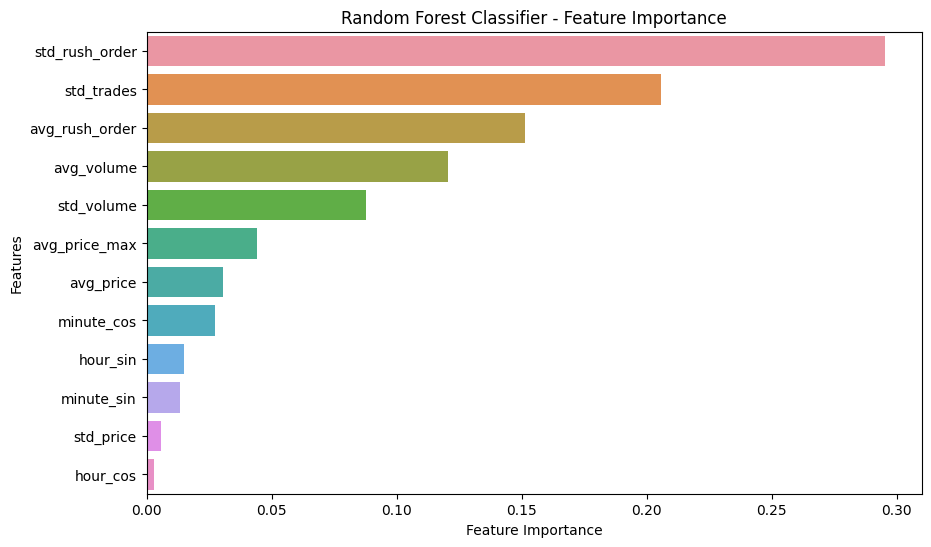

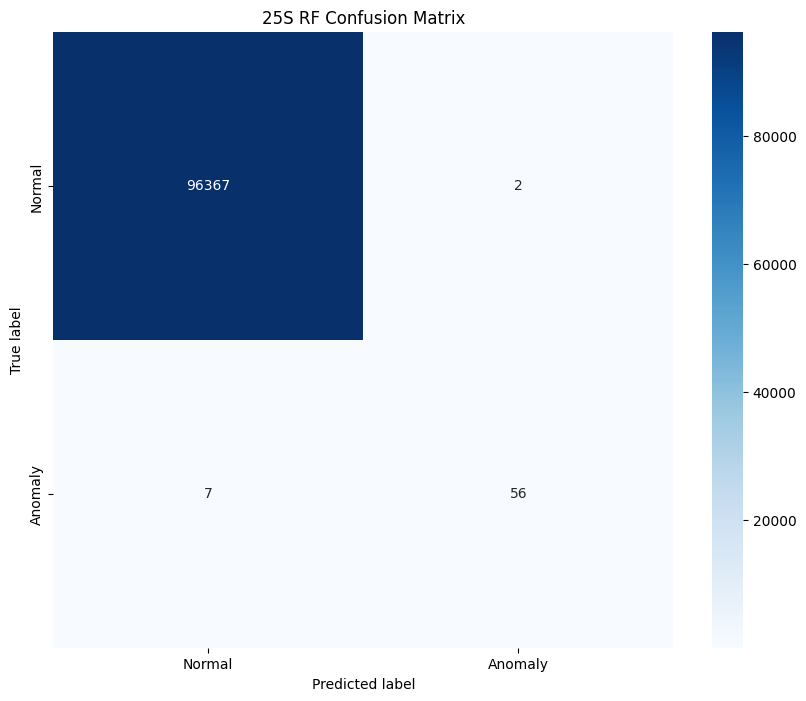

Processing: 5 folds - time freq 15S
Fitting model for 15S.
Recall: 0.873015873015873
Precision: 0.9649122807017544
F1 score: 0.9166666666666667
Processing: 5 folds - time freq 5S
Fitting model for 5S.
Recall: 0.7301587301587301
Precision: 0.9787234042553191
F1 score: 0.8363636363636363
0:07:22.282077


In [4]:
start = datetime.datetime.now()
precision_25S, recall_25S, auc_score_25S, confusion_matrix_25S= RFclassifier(time_freq='25S')
precision_15S, recall_15S, auc_score_15S, confusion_matrix_15S= RFclassifier(time_freq='15S')
precision_5S, recall_5S, auc_score_5S, confusion_matrix_5S= RFclassifier(time_freq='5S')
print(datetime.datetime.now() - start)

In [13]:
# 按这个顺序recall_5S precision_5S recall_15S precision_15S recall_25S precision_25S保存为pd.DataFrame
df_RF = pd.DataFrame({'RF': [recall_5S, precision_5S, recall_15S, precision_15S, recall_25S, precision_25S]})
df_RF.to_csv('./PR_Curve/RF_PR_Curve.csv', index=False)

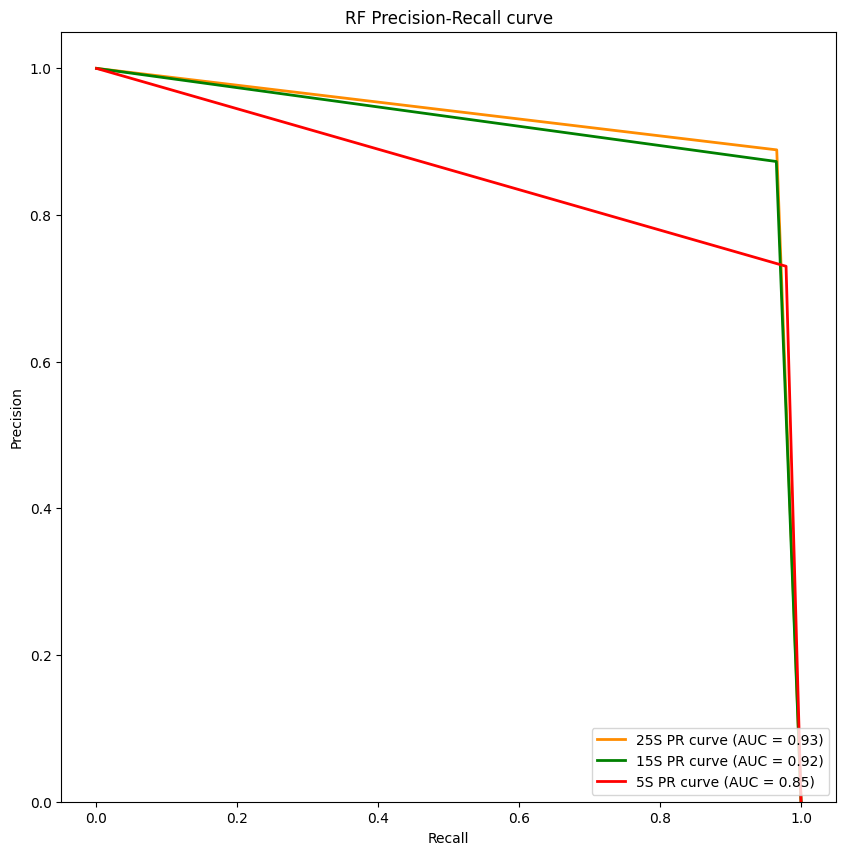

In [14]:
plt.figure(figsize=(10,10))
plt.plot(precision_25S, recall_25S, color='darkorange', lw=2, label='25S PR curve (AUC = %0.2f)' % auc_score_25S) # lw: line width
plt.plot(precision_15S, recall_15S, color='green', lw=2, label='15S PR curve (AUC = %0.2f)' % auc_score_15S) # lw: line width
plt.plot(precision_5S, recall_5S, color='red', lw=2, label='5S PR curve (AUC = %0.2f)' % auc_score_5S) # lw: line width
# plt.xlim([0.0, 1.0]) # x轴范围
plt.ylim([0.0, 1.05]) # y轴范围
plt.xlabel('Recall') # x轴标签
plt.ylabel('Precision') # y轴标签
plt.title('RF Precision-Recall curve') # 图片标题
plt.legend(loc="lower right") # 图例
plt.show()

Text(2658.9575163398695, 0.5, 'True label')

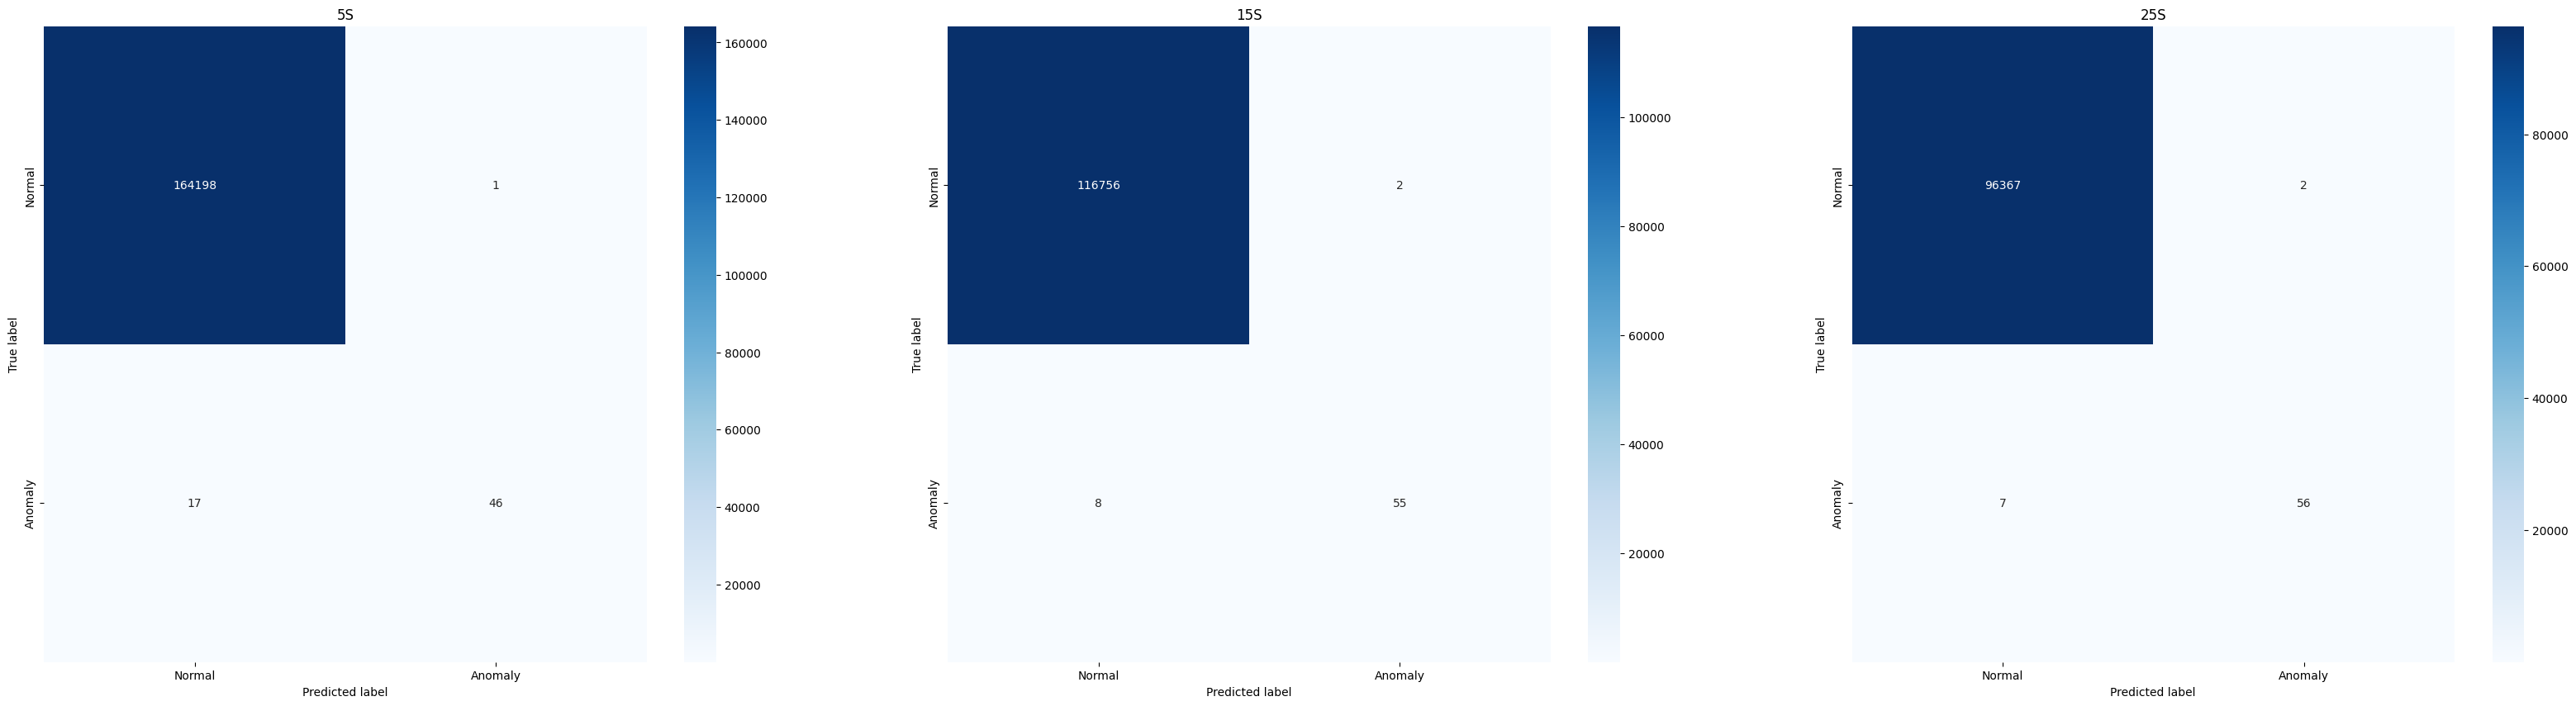

In [35]:
plt.figure(figsize=(40,10))
plt.subplot(1,3,1)
plt.title('5S')
sns.heatmap(confusion_matrix_5S, annot=True, fmt="d", cmap=plt.cm.Blues, xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.subplot(1,3,2)
plt.title('15S')
sns.heatmap(confusion_matrix_15S, annot=True, fmt="d", cmap=plt.cm.Blues, xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.subplot(1,3,3)
plt.title('25S')
sns.heatmap(confusion_matrix_25S, annot=True, fmt="d", cmap=plt.cm.Blues, xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted label')
plt.ylabel('True label')

### AdaBoost

In [26]:
def AdaBoostclassifier(time_freq):
    df = pd.read_csv('labeled_features/features_' + time_freq + '.csv', parse_dates=['date'])

    features = ['std_rush_order',
                'avg_rush_order',
                'std_trades',
                'std_volume',
                'avg_volume',
                'std_price',
                'avg_price',
                'avg_price_max',
                'hour_sin',
                'hour_cos',
                'minute_sin',
                'minute_cos']

    X = df[features]
    Y = df['gt'].astype(int).values.ravel()

    clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5), n_estimators=100, learning_rate=0.5, random_state=2023)

    cv_list = [5]
    processes = 7

    for n_fold in cv_list:
        print('Processing: {} folds - time freq {}'.format(n_fold, time_freq))
        y_pred = cross_val_predict(clf, X, Y.ravel(), cv=StratifiedKFold(n_splits=n_fold), n_jobs=processes)
        print(f'Fitting model for {time_freq}.')
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y.ravel(), train_size=0.8, random_state=2023)
        clf.fit(X_train, Y_train)
        y_pred = clf.predict(X_test)
        print('Recall: {}'.format(recall_score(Y_test, y_pred)))
        print('Precision: {}'.format(precision_score(Y_test, y_pred)))
        print('F1 score: {}'.format(f1_score(Y_test, y_pred)))

In [27]:
start = datetime.datetime.now()
AdaBoostclassifier(time_freq='25S')
AdaBoostclassifier(time_freq='15S')
AdaBoostclassifier(time_freq='5S')
print(datetime.datetime.now() - start)

Processing: 5 folds - time freq 25S
Fitting model for 25S.
Recall: 0.9041095890410958
Precision: 0.9295774647887324
F1 score: 0.9166666666666666
Processing: 5 folds - time freq 15S
Fitting model for 15S.
Recall: 0.8333333333333334
Precision: 0.9615384615384616
F1 score: 0.8928571428571429
Processing: 5 folds - time freq 5S
Fitting model for 5S.
Recall: 0.8307692307692308
Precision: 0.9473684210526315
F1 score: 0.8852459016393444
0:10:26.436344


### GBDT

In [28]:
def GBDTclassifier(time_freq):
    df = pd.read_csv('labeled_features/features_' + time_freq + '.csv', parse_dates=['date'])

    features = ['std_rush_order',
                'avg_rush_order',
                'std_trades',
                'std_volume',
                'avg_volume',
                'std_price',
                'avg_price',
                'avg_price_max',
                'hour_sin',
                'hour_cos',
                'minute_sin',
                'minute_cos']

    X = df[features]
    Y = df['gt'].astype(int).values.ravel()

    # clf = RandomForestClassifier(n_estimators=200, max_depth=5, random_state=2023)
    # clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5), n_estimators=100, learning_rate=0.5, random_state=0)
    clf = GradientBoostingClassifier(n_estimators=200, max_depth=5 ,learning_rate=0.5, random_state=2023)
    
    cv_list = [5]
    processes = 7

    for n_fold in cv_list:
        print('Processing: {} folds - time freq {}'.format(n_fold, time_freq))
        y_pred = cross_val_predict(clf, X, Y.ravel(), cv=StratifiedKFold(n_splits=n_fold), n_jobs=processes)
        print(f'Fitting model for {time_freq}.')
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y.ravel(), train_size=0.8, random_state=2023)
        clf.fit(X_train, Y_train)
        y_pred = clf.predict(X_test)
        print('Recall: {}'.format(recall_score(Y_test, y_pred)))
        print('Precision: {}'.format(precision_score(Y_test, y_pred)))
        print('F1 score: {}'.format(f1_score(Y_test, y_pred)))

In [29]:
start = datetime.datetime.now()
GBDTclassifier(time_freq='25S')
GBDTclassifier(time_freq='15S')
GBDTclassifier(time_freq='5S')
print(datetime.datetime.now() - start)

Processing: 5 folds - time freq 25S
Fitting model for 25S.
Recall: 0.7123287671232876
Precision: 0.7123287671232876
F1 score: 0.7123287671232877
Processing: 5 folds - time freq 15S
Fitting model for 15S.
Recall: 0.18333333333333332
Precision: 0.0650887573964497
F1 score: 0.09606986899563319
Processing: 5 folds - time freq 5S
Fitting model for 5S.
Recall: 0.7692307692307693
Precision: 0.746268656716418
F1 score: 0.7575757575757576
0:15:27.321066


### Isolation Forest

In [15]:
def Isolation_Forest(time_freq):
    df = pd.read_csv('labeled_features/features_' + time_freq + '.csv', parse_dates=['date'])

    features = ['std_rush_order',
                'avg_rush_order',
                'std_trades',
                'std_volume',
                'avg_volume',
                'std_price',
                'avg_price',
                'avg_price_max',
                'hour_sin',
                'hour_cos',
                'minute_sin',
                'minute_cos']

    X = df[features]
    Y = df['gt'].astype(int).values.ravel()

    # split train and test data
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=2023)

    # set contamination range
    contamination = np.linspace(0.0001, 0.01, 100)

    # plot recall, precision and f1 score
    recall = []
    precision = []
    f1 = []
    for c in contamination:
        clf = IsolationForest(n_estimators=100, max_samples='auto', contamination=c, max_features=1.0, bootstrap=False, n_jobs=-1, random_state=2023, verbose=0)
        clf.fit(X_train)
        y_pred = clf.predict(X_test)
        y_pred[y_pred == 1] = 0
        y_pred[y_pred == -1] = 1
        recall.append(recall_score(y_test, y_pred))
        precision.append(precision_score(y_test, y_pred))
        f1.append(f1_score(y_test, y_pred))

    best_threshold = contamination[np.argmax(f1)]
    print('Best threshold: ', best_threshold)
    print('Best f1 score: ', np.max(f1))
    print('Best recall: ', recall[np.argmax(f1)])
    print('Best precision: ', precision[np.argmax(f1)])


    plt.figure(figsize=(10, 6))
    plt.plot(contamination, recall, label='Recall')
    plt.plot(contamination, precision, label='Precision')
    plt.plot(contamination, f1, label='F1 score')
    plt.xlabel('Contamination')
    plt.ylabel('Score')
    plt.title('Isolation Forest - Contamination vs. Score')
    plt.legend()
    plt.show()

    # # plot confusion matrix
    # plt.figure(figsize=(10, 6))
    # cm = confusion_matrix(y_test, y_pred)
    # sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    # plt.title('Isolation Forest - Confusion Matrix')
    # plt.xlabel('Predicted')
    # plt.ylabel('Actual')
    # plt.show()


Best threshold:  0.0006000000000000001
Best f1 score:  0.6616541353383458
Best recall:  0.6027397260273972
Best precision:  0.7333333333333333


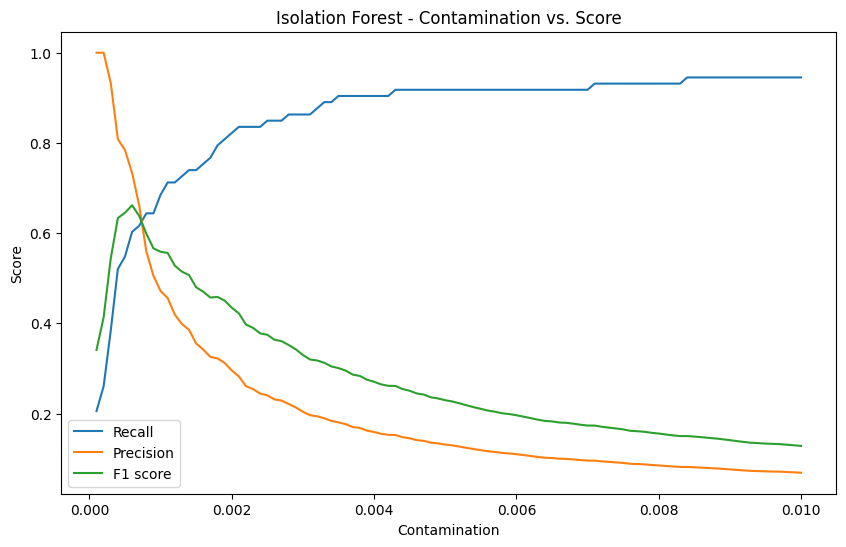

In [16]:
Isolation_Forest('25S')

Best threshold:  0.0006000000000000001
Best f1 score:  0.6446280991735538
Best recall:  0.65
Best precision:  0.639344262295082


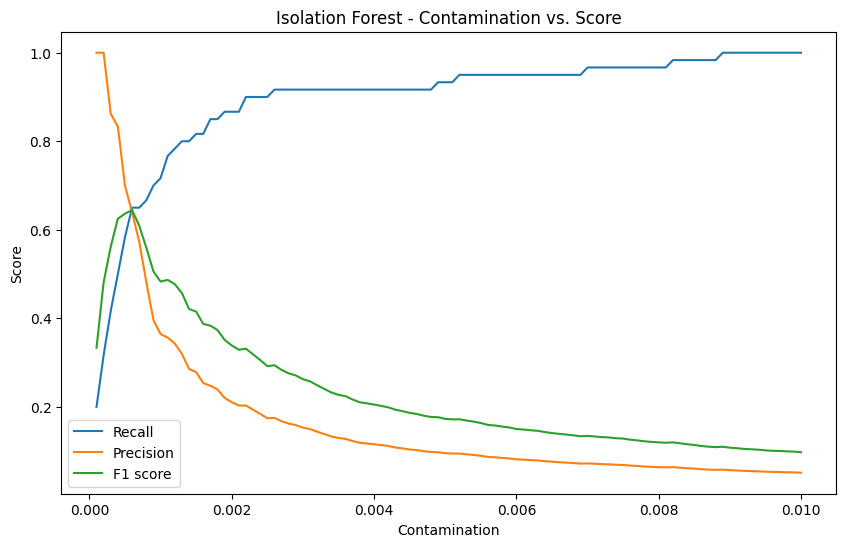

In [17]:
Isolation_Forest('15S')

Best threshold:  0.0002
Best f1 score:  0.6262626262626263
Best recall:  0.47692307692307695
Best precision:  0.9117647058823529


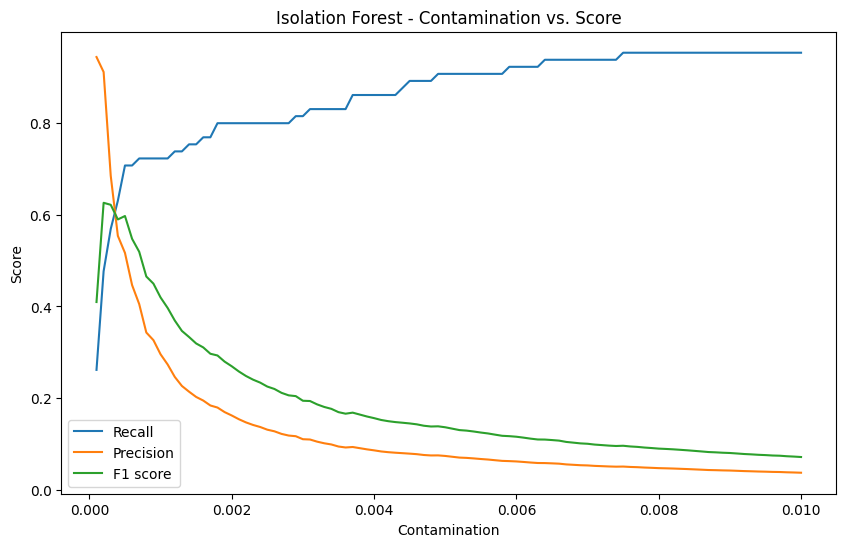

In [18]:
Isolation_Forest('5S')

### OCSVM

In [19]:
def ocsvm(time_freq):
    print('Processing: time freq {}'.format(time_freq))

    df = pd.read_csv('labeled_features/features_' + time_freq + '.csv', parse_dates=['date'])

    features = ['std_rush_order',
                'avg_rush_order',
                'std_trades',
                'std_volume',
                'avg_volume',
                'std_price',
                'avg_price',
                'avg_price_max',
                'hour_sin',
                'hour_cos',
                'minute_sin',
                'minute_cos']

    X = df[features]
    Y = df['gt'].astype(int).values.ravel()

    # clf = RandomForestClassifier(n_estimators=200, max_depth=5, random_state=2023)
    # clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5), n_estimators=100, learning_rate=0.5, random_state=0)
    
    # split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify=Y , random_state=2023)

    # define model
    clf = OneClassSVM(kernel='rbf', nu=0.1, gamma=0.1)

    # train on normal data
    trainX = X_train[y_train == 0]

    # fit model
    clf.fit(trainX)

    # predict on trian set
    y_pred_train = clf.predict(X_train)
    print('Train set:')
    print('Recall: {}'.format(recall_score(y_train, y_pred_train)))
    print('Precision: {}'.format(precision_score(y_train, y_pred_train)))
    print('F1 score: {}'.format(f1_score(y_train, y_pred_train)))

    # predict on test set
    y_pred_test = clf.predict(X_test)
    print('Test set:')
    print('Recall: {}'.format(recall_score(y_test, y_pred_test)))
    print('Precision: {}'.format(precision_score(y_test, y_pred_test)))
    print('F1 score: {}'.format(f1_score(y_test, y_pred_test)))




In [20]:
start = datetime.datetime.now()
ocsvm(time_freq='25S')
ocsvm(time_freq='15S')
ocsvm(time_freq='5S')
print(datetime.datetime.now() - start)

Processing: time freq 25S
Train set:


ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].